## Importing the Required Libraries

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
# split data into train and test
from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models
# SVM classifier from scikit learn
from sklearn.svm import LinearSVC

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler



%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Preparing the Data

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [3]:
stopwords = stopwords.words("english")

In [4]:
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
filename  = '../../Data/Real and fake news/news'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
orig_df = orig_df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [8]:
orig_df["text"] = orig_df["text"].astype(str)
orig_df["label"] = orig_df["label"].astype(str)
orig_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [9]:
df = orig_df

In [10]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [11]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [12]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

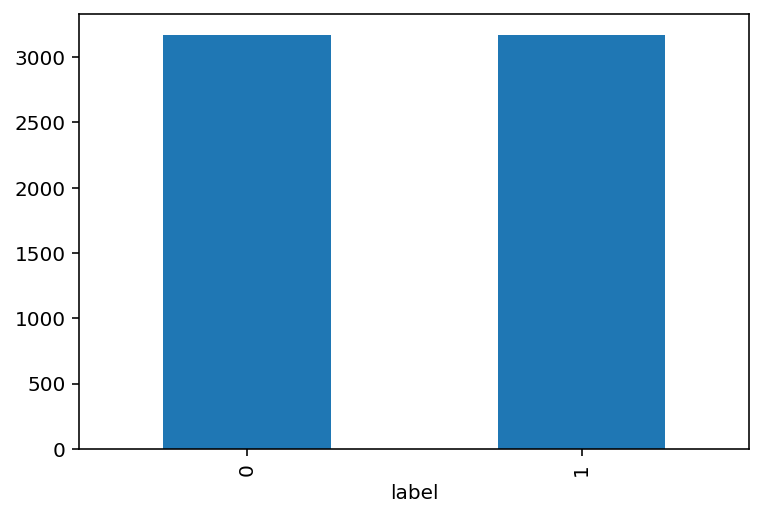

In [13]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [14]:
data=data.sample(frac=1).reset_index(drop=True)

In [15]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [16]:
import re
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [17]:
data.head()

,text,label
0,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
1,But the numbers were a boring datapoint in an ...,1
2,Trump Presents Plan To Expand U S Navy To 350 ...,0
3,And they are looking for someone who could app...,1
4,With debate gearing up over the coming expirat...,1


In [18]:
print(len(data))

6341


In [19]:
# data = orig_df['Text']

data['text'].head()

0    Google Pinterest Digg Linkedin Reddit Stumbleu...
1    But the numbers were a boring datapoint in an ...
2    Trump Presents Plan To Expand U S Navy To 350 ...
3    And they are looking for someone who could app...
4    With debate gearing up over the coming expirat...
Name: text, dtype: object

In [20]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data['text'])

In [21]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['be', 'campaign', 'trail', 'stumping', 'when', 'start', 'brutally', 'mock', 'learn', 'campaign', 'have', 'take', 'away', 'account', 'final', 'day', 'lead', 'election', 'president', 'help']


In [22]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['be', 'campaign', 'trail', 'stumping', 'when', 'start', 'brutally', 'mock', 'learn', 'campaign', 'have', 'take', 'away', 'account', 'final', 'day', 'lead', 'election', 'president', 'help']


In [23]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [24]:
len(corpus)

6341

In [25]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                            id2word=id2word,
#                                            num_topics=15,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=50,
#                                            alpha="auto")

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=15,
                                           chunksize=100,
                                           workers=7, # Num. Processing Cores - 1
                                           passes=50,
                                           eval_every = 1,
                                           per_word_topics=True)

In [26]:
lda_model.save("test_model.model")

In [27]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [28]:
train_vecs = []
for i in range(len(data)):
    top_topics = new_model.get_document_topics(corpus[i][:-1], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(data.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [29]:
train_vecs[2]

[0.08697095,
 0.00073376857,
 0.28901333,
 0.13926576,
 0.0007337688,
 0.09024078,
 0.0007337683,
 0.15542343,
 0.00073376857,
 0.00073376956,
 0.0007337687,
 0.23248182,
 0.0007337688,
 0.0007337679,
 0.000733768,
 1368]

In [30]:
# Using similar split 70/30
X = np.array(train_vecs)
y = np.array(data.label)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.30, random_state=100)

In [31]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [32]:
model2 = LinearSVC(random_state=10, tol=1e-5, verbose=1, max_iter=1000000)
model2.fit(X_train_scale, y_train)
y_pred2 = model2.predict(X_test_scale)

[LibLinear].............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [33]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[765 172]
 [207 759]]
Accuracy Score : 0.8008407777193904
Report : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       937
           1       0.82      0.79      0.80       966

    accuracy                           0.80      1903
   macro avg       0.80      0.80      0.80      1903
weighted avg       0.80      0.80      0.80      1903



In [34]:
# test_doc = corpus[-1]

# vector = new_model[test_doc]
# print (vector)
# For topic importance
# def Sort(sub_li):
#     sub_li.sort(key = lambda x: x[1])
#     sub_li.reverse()
#     return (sub_li)
# new_vector = Sort(vector)
# print (new_vector)

## Vizualizing the Data

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.048288  0.283446       1        1  15.091083
0     -0.134395  0.024879       2        1  12.718946
7     -0.261952  0.140265       3        1   9.822675
11     0.090484  0.131127       4        1   9.624064
6      0.232271  0.200377       5        1   8.532220
8     -0.214768  0.323393       6        1   7.497473
2      0.047076 -0.104393       7        1   7.064229
12     0.151821  0.356756       8        1   6.338411
13    -0.178745 -0.317314       9        1   5.911395
1     -0.357830 -0.024700      10        1   5.184169
10     0.353095  0.057582      11        1   4.624391
3      0.372880 -0.147511      12        1   3.592580
9     -0.315097 -0.232451      13        1   2.349054
14     0.209409 -0.294809      14        1   0.988181
5      0.054039 -0.396645      15        1   0.661131, topic_info=           Term          Freq         Total Category  logprob  loglift
9            be  27142.000000  27142.000000  Default  30.0000  30.0000
80          say  20394.000000  20394.000000  Default  29.0000  29.0000
38         have   8680.000000   8680.000000  Default  28.0000  28.0000
24           do   9056.000000   9056.000000  Default  27.0000  27.0000
89        state   6534.000000   6534.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
125         bad     46.760569   1053.698992  Topic15  -5.3300   1.9040
158     country     48.633153   3338.772862  Topic15  -5.2907   0.7899
89        state     46.420640   6534.138209  Topic15  -5.3373   0.0719
377  government     44.757256   4055.759780  Topic15  -5.3738   0.5123
75           re     42.878612   2601.763011  Topic15  -5.4167   0.9134

[1127 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3143      1  0.067487  abortion
3143      2  0.148817  abortion
3143      3  0.070947  abortion
3143      6  0.048452  abortion
3143     11  0.664484  abortion
...     ...       ...       ...
2040      6  0.089264     youth
2040      8  0.041657     youth
2040     10  0.833134     youth
9374      3  0.944505      zeal
5161      4  0.987904   zionist

[3318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 8, 12, 7, 9, 3, 13, 14, 2, 11, 4, 10, 15, 6])

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
